# Model quantization investigations

[quantization.py](quantization.py) provides a few functions used in this notebook.

In [1]:
from quantization import get_array_size_in_bytes, dequantize_weights, dequantize_weights_per_layer
from model_quantization import load_model, quantize_model_per_layer
import torch
from math import sqrt, ceil
import numpy as np
from matplotlib import pyplot as plt
from metrics import compute_metrics
from tqdm import tqdm
from shared import (
    ACCURACY, PRECISION, RECALL, F1_SCORE, IOU,
    VALIDATION, TEST, TRAIN,
    DEVICE
)
from pathlib import Path
import pandas as pd
%load_ext autoreload
%autoreload 2
device = DEVICE
from evaluate import evaluate_model, evaluate_test_mode
    

In [8]:
exp = 201 # Pick up a model to quantize
exp = 204
num_bits=4 # If you want to change the number of bits, you need to reload the model
# you can use 3 bits , it still works kind of correctly
model, dl_dict = load_model(exp)
original_model, _ = load_model(exp, get_data_loaders_flag=False)

Using augmentations ['h_roll', 'flip']
TOTAL ELEMENTS 7211
TOTAL ELEMENTS 2463
Got NaN in image /Data/geosciences/TP_5/data/validation/images/well_15_patch_201.npy
Got NaN in image /Data/geosciences/TP_5/data/validation/images/well_15_patch_202.npy
TOTAL ELEMENTS 2538


In [9]:
labeled_dict = evaluate_test_mode(original_model, dl_dict, save_path=Path(f'__submission_{exp:04d}.csv'))

  0%|          | 0/80 [00:00<?, ?it/s]

100%|██████████| 80/80 [00:10<00:00,  7.93it/s]


In [10]:
evaluate_model(original_model, dl_dict)

  0%|          | 0/77 [00:00<?, ?it/s]

100%|██████████| 77/77 [00:09<00:00,  7.90it/s]


Metrics on validation set
{'accuracy': 0.9698517918586731, 'precision': 0.7375080585479736, 'recall': 0.7799708247184753, 'dice': 0.742674708366394, 'iou': 0.66373610496521}


In [12]:
params = torch.cat([p.flatten() for p in model.parameters() if p.requires_grad])
params = params.detach().cpu().numpy()
print(len(params), "=", model.count_parameters(), "->", get_array_size_in_bytes(params), "Bytes")
quantized_weights, quantization_parameters = quantize_model_per_layer(model, num_bits=num_bits)
params_dequant = dequantize_weights_per_layer(quantized_weights, quantization_parameters)

# Reinject dequantized weights into the model
for name, param in model.named_parameters():
    if name in params_dequant:
        param.data = torch.nn.Parameter(torch.from_numpy(params_dequant[name])).to(device=device)
        print(name, "has been updated with quantized weights")

7.26 Mb
1904135 = 1904135 -> 7616540 Bytes
Nonstandard: Number of bits better be 16 or 8 - otherwise need to pack but not done here!
Nonstandard: Number of bits better be 16 or 8 - otherwise need to pack but not done here!
Nonstandard: Number of bits better be 16 or 8 - otherwise need to pack but not done here!
Nonstandard: Number of bits better be 16 or 8 - otherwise need to pack but not done here!
Nonstandard: Number of bits better be 16 or 8 - otherwise need to pack but not done here!
Nonstandard: Number of bits better be 16 or 8 - otherwise need to pack but not done here!
Nonstandard: Number of bits better be 16 or 8 - otherwise need to pack but not done here!
Nonstandard: Number of bits better be 16 or 8 - otherwise need to pack but not done here!
Nonstandard: Number of bits better be 16 or 8 - otherwise need to pack but not done here!
Nonstandard: Number of bits better be 16 or 8 - otherwise need to pack but not done here!
1.81 Mb
7.26 Mb
compression ratio = 4.004
conv_in_modalit

In [13]:
evaluate_model(model, dl_dict)

100%|██████████| 77/77 [00:09<00:00,  8.05it/s]


Metrics on validation set
{'accuracy': 0.9708576202392578, 'precision': 0.7469444870948792, 'recall': 0.7717781662940979, 'dice': 0.7432085871696472, 'iou': 0.6651002764701843}


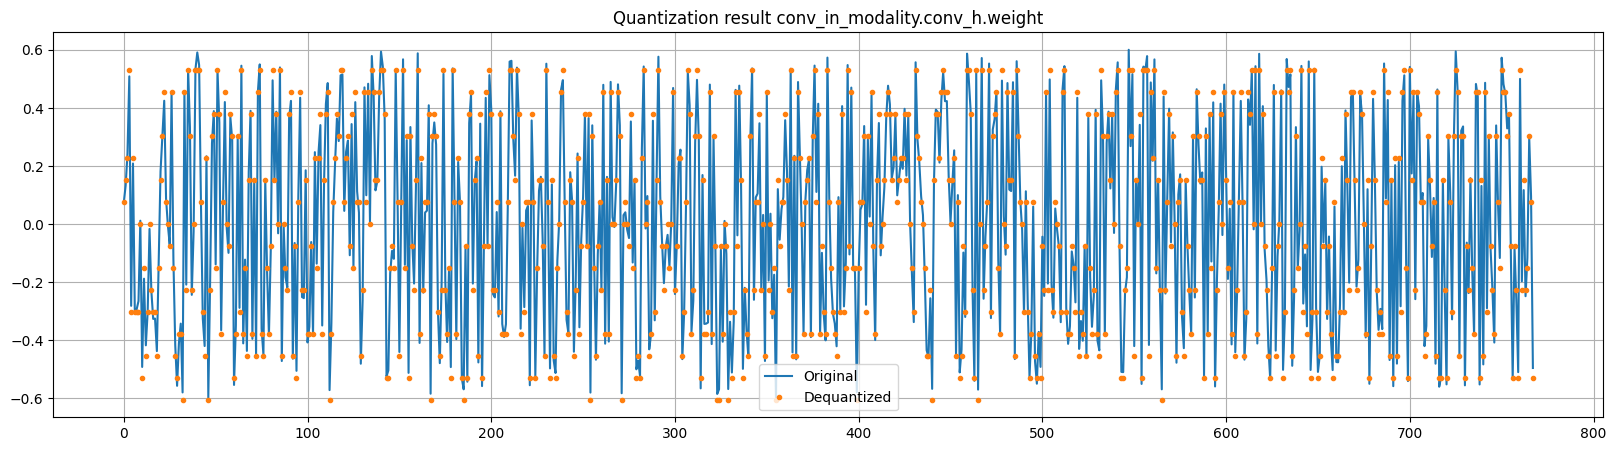

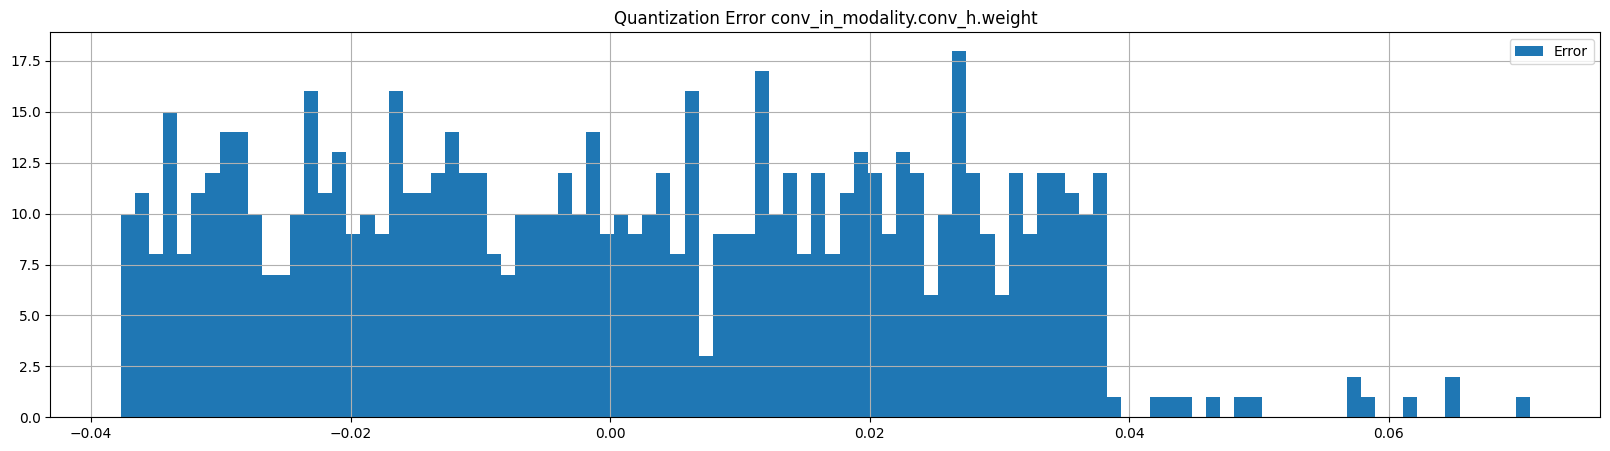

In [19]:
layer_key= "conv_in_modality.conv_h.weight"
model_params_dict = dict(original_model.named_parameters())
params_no_qant = model_params_dict[layer_key].flatten().detach().cpu().numpy()
# Back to the original weights

plt.figure(figsize=(20,5))
plt.plot(params_no_qant, label="Original")
plt.plot(params_dequant[layer_key].flatten(), ".", label="Dequantized")
plt.legend()
plt.grid()
plt.title(f"Quantization result {layer_key}")
plt.show()
plt.figure(figsize=(20,5))
plt.hist(params_no_qant-params_dequant[layer_key].flatten(), bins=100, label="Error")
plt.legend()
plt.title(f"Quantization Error {layer_key}")
plt.grid()
plt.show()

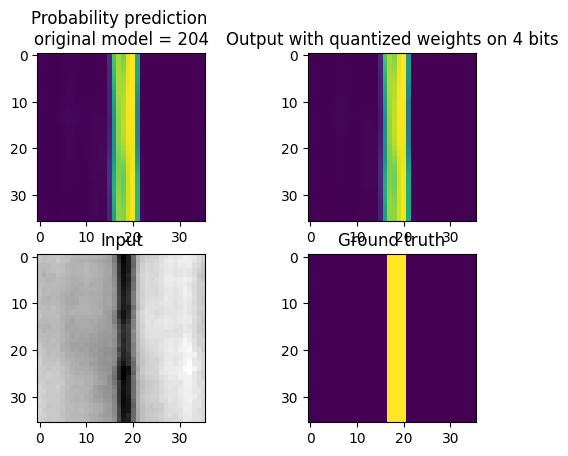

In [27]:
img, label = next(iter(dl_dict[VALIDATION]))
with torch.no_grad():
    output = original_model(img)
    output_with_qant = model(img)
selected_index = 12 # image to pick from the first validation batch


plt.figsize = (10, 10)
plt.subplot(2, 2, 1)
plt.imshow(torch.sigmoid(output[selected_index, 0, ...]).detach().cpu().numpy())
plt.title(f'Probability prediction \noriginal model = {exp}')
plt.subplot(2, 2, 2)
plt.imshow(torch.sigmoid(output_with_qant[selected_index, 0, ...]).detach().cpu().numpy())
plt.title(f"Output with quantized weights on {num_bits} bits")

plt.subplot(2, 2, 3)
plt.title("Input")
plt.imshow(img[selected_index, 0, ...].detach().cpu().numpy().astype(float), cmap="gray")

plt.subplot(2, 2, 4)
plt.title("Ground truth")
plt.imshow(label[selected_index, 0, ...].detach().cpu().numpy().astype(float))
plt.show()

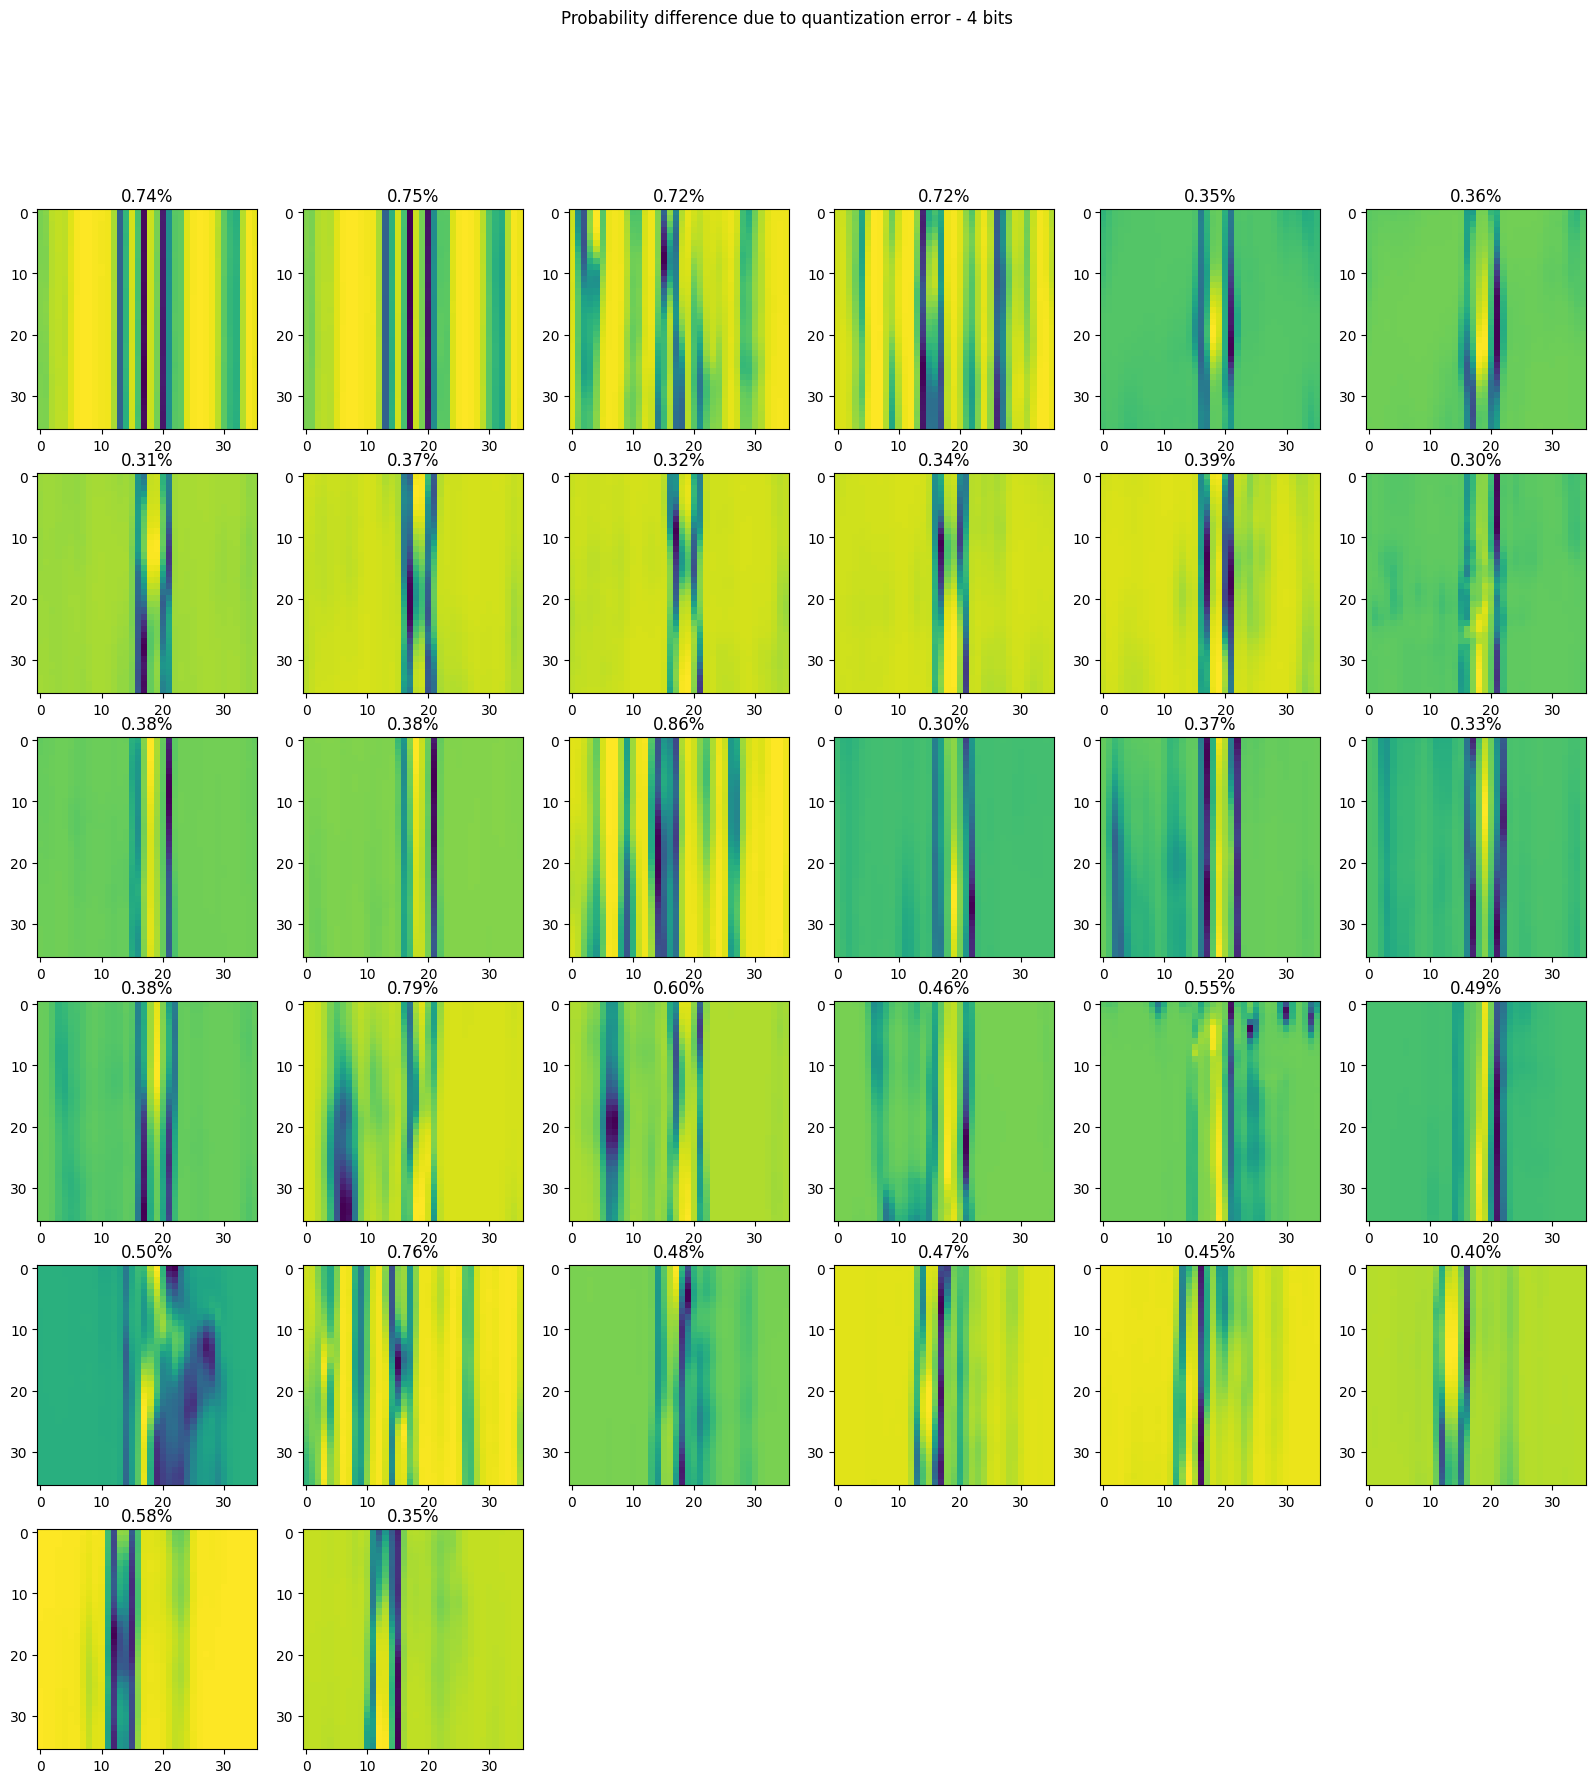

In [28]:
error = torch.sigmoid(output_with_qant)-torch.sigmoid(output)
error = error[:, 0, ...].detach().cpu().numpy()
plt.figure(figsize=(20, 20))
n = int(sqrt(error.shape[0])+0.5)
for idx in range(error.shape[0]):
    plt.subplot(n, ceil(error.shape[0]/n), idx+1)
    plt.title(f"{np.abs(error)[idx].mean():.2%}")
    plt.imshow(error[idx])
plt.suptitle(f"Probability difference due to quantization error - {num_bits} bits")
plt.show()

# Global weights distribution

In [32]:
# model, dl_dict = load_model(exp) # Reload model before doing anything stupid and visualize quantized weights
original_params = torch.cat([p.flatten() for p in original_model.parameters() if p.requires_grad])
original_params = original_params.detach().cpu().numpy()

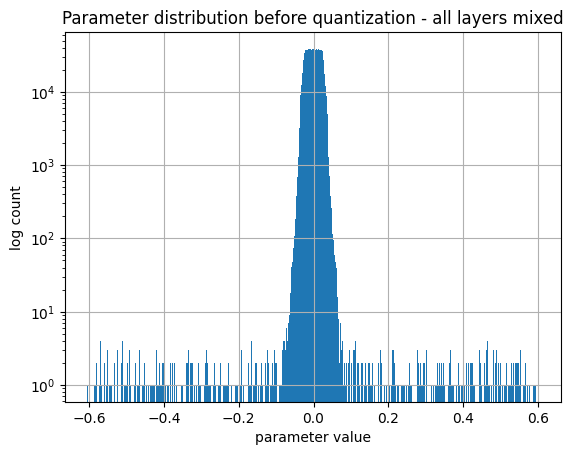

In [33]:
plt.hist(original_params, bins=1000)
plt.yscale('log')
plt.ylabel('log count')
plt.xlabel('parameter value')
plt.grid()
plt.title('Parameter distribution before quantization - all layers mixed')
plt.show()


# Need  for per-layer quantization
The following graph shows that if we perform global model quantization (same scaling for all weights, we will loose a lot of precision as each layer's weight have a slightly different dynamic).

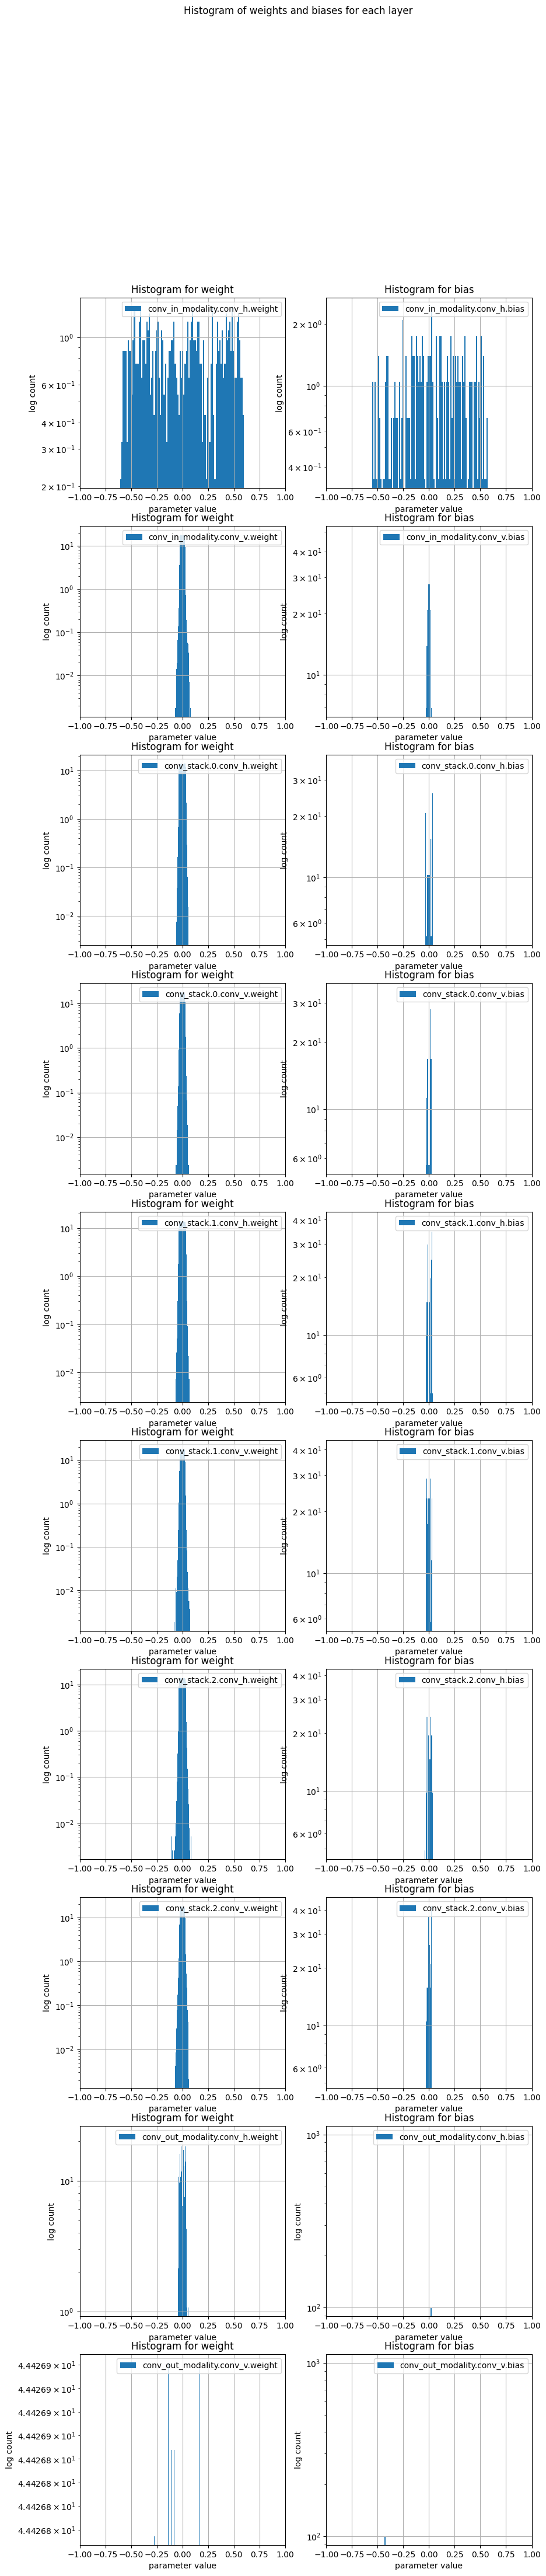

In [34]:
from matplotlib import pyplot as plt
tot = len([1 for _ in original_model.named_parameters()])
plt.figure(figsize=(10, tot//2*5))
for idx, (name, param) in enumerate(original_model.named_parameters()):
    if 'bias' not in name:
        plt.subplot(tot//2, 2, idx//2 * 2 + 1)
    else:
        plt.subplot(tot//2, 2, idx//2 * 2 + 2)
    if param.requires_grad:
        layer_params = param.detach().cpu().numpy().flatten()
        plt.hist(layer_params, bins=100, density=True, alpha=1, label=name)
        # plt.title(f'Histogram for Layer: {name}')
        plt.title('Histogram for weight' if 'weight' in name else 'Histogram for bias')
        plt.yscale('log')
        plt.ylabel('log count')
        plt.xlabel('parameter value')
        plt.legend()
        plt.xlim(-1., 1.)
        plt.grid()
plt.suptitle('Histogram of weights and biases for each layer')
plt.show()